In [1]:
import numpy as np
import pandas as pd
np.random.seed(0)


In [2]:
folds_dir = './ml-100k/'

header = ['user_id', 'item_id', 'rating', 'timestamp']   
df = pd.read_csv(f'{folds_dir}u.data', sep='\t', names=header)
df.head()

,user_id,item_id,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [3]:
def get_all_users_and_items():
    header = ['user_id', 'item_id', 'rating', 'timestamp']   
    df = pd.read_csv(f'{folds_dir}u.data', sep='\t', names=header)
    users = df.user_id.unique()
    items = df.item_id.unique()
    return users, items
all_users_ids, all_items_ids = get_all_users_and_items()


In [4]:

def create_rating_matrix_from_raw_data(df):

    ratings = np.zeros((all_users_ids.shape[0], all_items_ids.shape[0]))

    for row in df.itertuples():
        ratings[row[1]-1][row[2]-1] = row[3]  
        
    return ratings


In [5]:
df = pd.read_csv(f'{folds_dir}u.data', sep='\t', names=header)
df.shape

ratings = create_rating_matrix_from_raw_data(df)
ratings.shape

(943, 1682)

In [6]:
import numpy as np
sparsity = float(len(np.nan_to_num(ratings).nonzero()[0]))
sparsity /= (ratings.shape[0] * ratings.shape[1])
sparsity *= 100
print('Sparsity: {:4.2f}%'.format(sparsity))

Sparsity: 6.30%


In [7]:
def train_test_split(ratings):
    test = np.zeros(ratings.shape)
    train = ratings.copy()
    for user in range(ratings.shape[0]):
        test_ratings = np.random.choice(ratings[user, :].nonzero()[0], 
                                        size=10, 
                                        replace=False)
        train[user, test_ratings] = 0.
        test[user, test_ratings] = ratings[user, test_ratings]
        
    # Test and training are truly disjoint
    assert(np.all((train * test) == 0)) 
    return train, test

In [8]:
train, test = train_test_split(ratings)

In [ ]:
def get_5_folds(folds_dir='./ml-100k/'):    
    header = ['user_id', 'item_id', 'rating', 'timestamp']
    folds = []
    
    for i in range(5):     
        print(f'{folds_dir}u{i+1}.base')
        df_train = pd.read_csv(f'{folds_dir}u{i+1}.base', sep='\t', names=header)
        df_test = pd.read_csv(f'{folds_dir}u{i+1}.test', sep='\t', names=header)   
        
        rating_train = create_rating_matrix_from_raw_data(df_train)
        rating_test  = create_rating_matrix_from_raw_data(df_test)        
           
        folds.append((rating_train, rating_test))
    return folds
folds = get_5_folds()

for fold in folds:
    print(fold[0].shape, fold[1].shape)

In [ ]:
train_data, test_data = folds[0]
train_data.shape

In [15]:
import numpy as np
from numpy.linalg import solve
from sklearn.metrics import mean_squared_error


def get_mse(pred, actual):
    # Ignore nonzero terms.
    pred = pred[actual.nonzero()].flatten()
    actual = actual[actual.nonzero()].flatten()
    return mean_squared_error(pred, actual)


class MatrixFactorizationALS:
    def __init__(self,
                 ratings,
                 n_factors=40,
                 item_reg=0.0,
                 user_reg=0.0,
                 verbose=False):
        self.ratings = ratings
        self.n_users, self.n_items = ratings.shape
        self.n_factors = n_factors
        self.item_reg = item_reg
        self.user_reg = user_reg
        self._v = verbose

    def als_step_user(self,
                      latent_vectors,
                      fixed_vecs,
                      ratings,
                      _lambda):
        YTY = fixed_vecs.T.dot(fixed_vecs)
        lambdaI = np.eye(YTY.shape[0]) * _lambda

        for u in range(latent_vectors.shape[0]):
            latent_vectors[u, :] = solve((YTY + lambdaI), ratings[u, :].dot(fixed_vecs))
        return latent_vectors

    def als_step_item(self,
                      latent_vectors,
                      fixed_vecs,
                      ratings,
                      _lambda):
        XTX = fixed_vecs.T.dot(fixed_vecs)
        lambdaI = np.eye(XTX.shape[0]) * _lambda

        for i in range(latent_vectors.shape[0]):
            latent_vectors[i, :] = solve((XTX + lambdaI), ratings[:, i].T.dot(fixed_vecs))
        return latent_vectors

    def train(self, n_iter=10):
        """ Train model for n_iter iterations from scratch."""
        # initialize latent vectors
        self.user_vecs = np.random.normal(scale=1. / self.n_factors,
                                          size=(self.n_users, self.n_factors))
        self.item_vecs = np.random.normal(scale=1. / self.n_factors,
                                          size=(self.n_items, self.n_factors))
        self.partial_train(n_iter)

    def partial_train(self, n_iter):
        ctr = 1
        while ctr <= n_iter:
            if ctr % 10 == 0 and self._v:
                print(f'\tcurrent iteration: {ctr}')
            self.user_vecs = self.als_step_user(self.user_vecs,
                                                self.item_vecs,
                                                self.ratings,
                                                self.user_reg)
            self.item_vecs = self.als_step_item(self.item_vecs,
                                                self.user_vecs,
                                                self.ratings,
                                                self.item_reg)

            ctr += 1

    def predict(self, u, i):
        return self.user_vecs[u, :].dot(self.item_vecs[i, :].T)

    def predict_all(self):
        predictions = np.zeros((self.user_vecs.shape[0],
                                self.item_vecs.shape[0]))
        for u in range(self.user_vecs.shape[0]):
            for i in range(self.item_vecs.shape[0]):
                predictions[u, i] = self.predict(u, i)

        return predictions

    def calculate_learning_curve(self, iter_array, test):
        iter_array.sort()
        self.train_mse = []
        self.test_mse = []
        iter_diff = 0
        for (i, n_iter) in enumerate(iter_array):
            if self._v:
                print(f'Iteration: {n_iter}')
            if i == 0:
                self.train(n_iter - iter_diff)
            else:
                self.partial_train(n_iter - iter_diff)

            predictions = self.predict_all()

            self.train_mse += [get_mse(predictions, self.ratings)]
            self.test_mse += [get_mse(predictions, test)]
            if self._v:
                print(f'Train mse: {str(self.train_mse[-1])}')
                print(f'Test mse: {str(self.test_mse[-1])}')
            iter_diff = n_iter


In [16]:
MF_ALS = MatrixFactorization(train, n_factors=40, \
                    user_reg=0.0, item_reg=0.0, verbose=True)
iter_array = [1, 2, 5, 10, 25, 50, 100]
MF_ALS.calculate_learning_curve(iter_array, test)

Iteration: 1
Train mse: 5.432576495368798
Test mse: 9.86092561961515
Iteration: 2
Train mse: 4.214419478631128
Test mse: 8.617990670480376
Iteration: 5
Train mse: 3.9712319959888807
Test mse: 8.46098206557439
Iteration: 10
Train mse: 3.9349021551909393
Test mse: 8.450793648665558
Iteration: 25
	current iteration: 10
Train mse: 3.924911105021586
Test mse: 8.45928512541879
Iteration: 50
	current iteration: 10
	current iteration: 20
Train mse: 3.9237737238957457
Test mse: 8.463674633642704
Iteration: 100
	current iteration: 10
	current iteration: 20
	current iteration: 30
	current iteration: 40
	current iteration: 50
Train mse: 3.923370043600883
Test mse: 8.466561433543408


In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

def plot_learning_curve(iter_array, model):
    plt.plot(iter_array, model.train_mse, \
             label='Training', linewidth=5)
    plt.plot(iter_array, model.test_mse, \
             label='Test', linewidth=5)


    plt.xticks(fontsize=16);
    plt.yticks(fontsize=16);
    plt.xlabel('iterations', fontsize=30);
    plt.ylabel('MSE', fontsize=30);
    plt.legend(loc='best', fontsize=20);

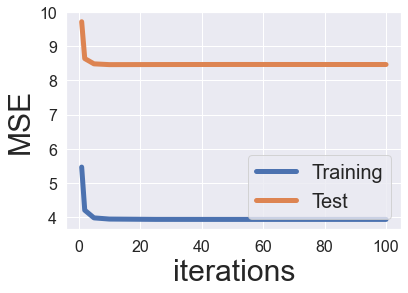

In [12]:
plot_learning_curve(iter_array, MF_ALS)